In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Input space transformation (dimensionality reduction)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import random_projection
from sklearn import cluster
from sklearn.random_projection import johnson_lindenstrauss_min_dim

import utils
from model import My_VGG as Model

from ClusteringAdvClassifier import ClusterAdversarialClassifier as Classifier

# Testing Cluster Adversarial Classifier

## Load Data

In [2]:
# MNIST
X_train, y_train, X_test, y_test = utils.load_mnist()
channels, size, classes = 1, 28, 10
dimensions = (size, size)

# Fashion MNIST
#X_train, y_train, X_test, y_test = utils.load_fashion_mnist()
#channels, size, classes = 1, 28, 10
#dimensions = (size, size)

# CIFAR-10
# X_train, y_train, X_test, y_test = utils.load_cifar10()
# channels, size, classes = 3, 32, 10
# dimensions = (size, size, channels)

## Load Baseline Model (adversarial training)

In [3]:
baseline_model = utils.load_VGG('trained_models/baseline_model.pt')

## Train Clustering Classifier

### Load Base Neural Network For Clustering Detector/Classifier

In [4]:
model = utils.load_VGG('trained_models/initial_model.pt')

### Input Space (Dimensionality Reduction) Transforms - optional

In [5]:
# SKLearn method for determining a "minimum" number of components to reduce the dataset to
#n_comp = johnson_lindenstrauss_min_dim(X_train.shape[0], eps=.99)

# Control (no transform): Wall time: 2min 53s, clean: 0.9733, adv: 0.8829
#transformer = None

# GaussianRandomProjection(n_components=374): Wall time: 1min 47s, clean: 0.9737, adv: 0.8892
# 2nd run: Wall time: 1min 52s, clean: 0.9727, adv: 0.911
#transformer = random_projection.GaussianRandomProjection(n_components=n_comp)

# SparseRandomProjection(n_components=374): Wall time: 1min 46s, clean: 0.9744, adv: 0.9247
# 2nd run: Wall time: 1min 47s, clean: 0.9706, adv: 0.8998
#transformer = random_projection.SparseRandomProjection(n_components=n_comp)

# PCA(n_components=374): Wall time: 1min 53s, clean: 0.9783, adv: 0.9137
# 2nd run: Wall time: 1min 32s, clean: 0.9757, adv: 0.9028
#transformer = PCA(n_components=n_comp)

# FeatureAgglomeration(n_clusters=10):  Wall time: 46.2 s, clean: 0.8512, adv: 0.782
#transformer = cluster.FeatureAgglomeration(n_clusters=10)

# UMAP
# transformer = umap.UMAP(n_components = n_comp,
#                         min_dist = 0.05,
#                         n_neighbors = 15,
#                         metric = "euclidean")

### Fitting the clustering classifier on clean data

In [6]:
# Trying out different parameters for the clustering algorithm:
# Base: C=1, no transform
# Clean data flagged as suspicious by detector: 2.820%
# {'0.02': 97.28999999999999, '0.04': 96.53, '0.08': 93.91000000000001, '0.16': 83.16, '0.24': 64.78, '0.32': 48.89}
# {'0.02': 3.9600000000000004, '0.04': 5.83, '0.08': 14.02, '0.16': 47.75, '0.24': 55.300000000000004, '0.32': 58.68}

# Evaluating on adversarial data
# Baseline Model Accuracies:  {'0.02': 98.7, '0.04': 98.88, '0.08': 99.11, '0.12': 99.18, '0.16': 99.06, '0.24': 96.96000000000001, '0.32': 84.33}

######### Best performing with DCT Transfrom
# C = 1, DCT transform 
# Clustering Model Accuracies:  {'0.02': 95.42, '0.04': 93.51, '0.08': 88.35, '0.12': 83.39, '0.16': 80.72, '0.24': 73.49, '0.32': 64.0}
# Clustering Detector Accuracies:  {'0.02': 6.97, '0.04': 13.26, '0.08': 37.21, '0.12': 46.31, '0.16': 47.23, '0.24': 48.39, '0.32': 50.74999999999999}

# C = 1, NO transform
# Clustering Model Accuracies:  {'0.02': 97.00999999999999, '0.04': 95.34, '0.08': 90.27, '0.12': 86.14, '0.16': 83.78, '0.24': 75.38, '0.32': 63.04}
# Clustering Detector Accuracies:  {'0.02': 5.74, '0.04': 12.22, '0.08': 36.980000000000004, '0.12': 46.36, '0.16': 47.31, '0.24': 48.35, '0.32': 51.82}

# C = 1, DCT on flattened image arrays:
# Clustering Model Accuracies:  {'0.02': 95.14, '0.04': 93.33, '0.08': 88.19, '0.12': 83.48, '0.16': 81.0, '0.24': 74.46000000000001, '0.32': 65.7}
# Clustering Detector Accuracies:  {'0.02': 7.16, '0.04': 13.38, '0.08': 37.19, '0.12': 46.36, '0.16': 47.15, '0.24': 47.69, '0.32': 48.6}

In [7]:
classifier = Classifier(model, SVC_C = 1, dct=True)

classifier.fit(X_train, y_train)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Evaluation

### Scoring classifiers on clean data

In [8]:
print("Baseline classifier on clean test data: %.3f%%" % (utils.eval_model(baseline_model, X_test, y_test) * 100))

print("\nCluster Classifier Accuracy on clean test data: %.3f%%" % (classifier.score(X_test, y_test) * 100))
print("Clean data flagged as suspicious by detector: %.3f%%" % (classifier.proportion_flagged * 100))

Baseline classifier on clean test data: 98.580%

Cluster Classifier Accuracy on clean test data: 95.820%
Clean data flagged as suspicious by detector: 4.710%


## Evaluating on adversarial data

Baseline training epsilon: 0.12

Current epsilon: 0.02


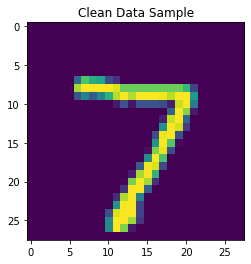

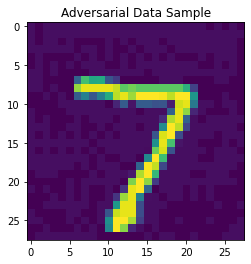

	Adversarial data only:
		Baseline classifier accuracy: 98.700%

		Cluster classifier accuracy: 95.140%
		Input data flagged as suspicious by detector: 7.160%

Current epsilon: 0.04


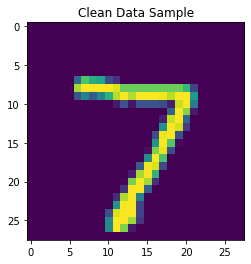

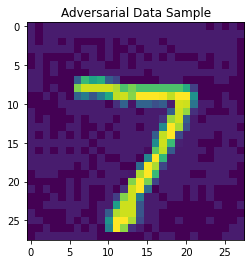

	Adversarial data only:
		Baseline classifier accuracy: 98.880%

		Cluster classifier accuracy: 93.330%
		Input data flagged as suspicious by detector: 13.380%

Current epsilon: 0.08


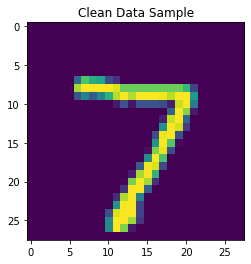

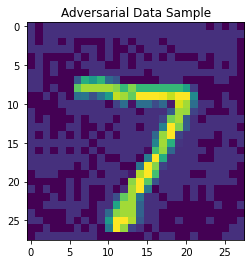

	Adversarial data only:
		Baseline classifier accuracy: 99.110%

		Cluster classifier accuracy: 88.190%
		Input data flagged as suspicious by detector: 37.190%

Current epsilon: 0.12


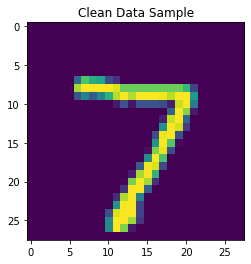

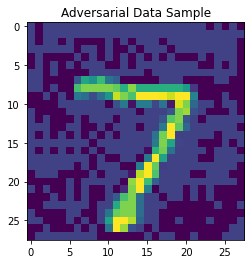

	Adversarial data only:
		Baseline classifier accuracy: 99.180%

		Cluster classifier accuracy: 83.480%
		Input data flagged as suspicious by detector: 46.360%

Current epsilon: 0.16


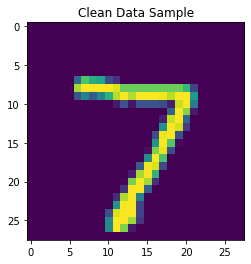

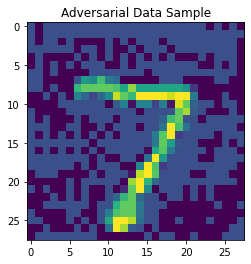

	Adversarial data only:
		Baseline classifier accuracy: 99.060%

		Cluster classifier accuracy: 81.000%
		Input data flagged as suspicious by detector: 47.150%

Current epsilon: 0.24


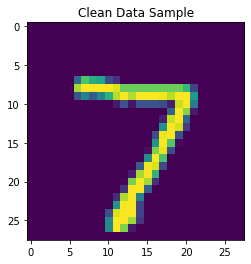

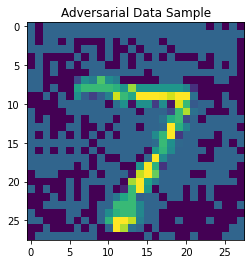

	Adversarial data only:
		Baseline classifier accuracy: 96.960%

		Cluster classifier accuracy: 74.460%
		Input data flagged as suspicious by detector: 47.690%

Current epsilon: 0.32


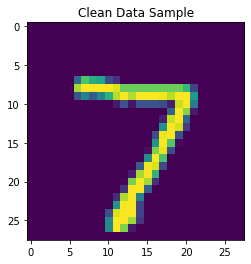

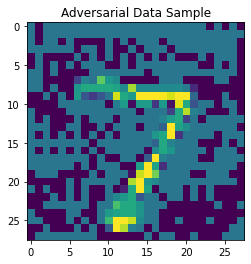

	Adversarial data only:
		Baseline classifier accuracy: 84.340%

		Cluster classifier accuracy: 65.700%
		Input data flagged as suspicious by detector: 48.600%


In [9]:
test_eps = [2e-2, 4e-2, 8e-2, 1.2e-1, 1.6e-1, 2.4e-1, 3.2e-1]
print("Baseline training epsilon: %.2f" % (1.2e-1))

baseline_performance = dict()
clustering_classifier_performance = dict()
clustering_detector_performance = dict()

test_dataloader = utils.create_dataloader(X_test, y_test)

for eps in test_eps:
    adv_test_data = utils.add_adversarial_noise(model, test_dataloader, eps=eps)
    
    print("\nCurrent epsilon: %.2f" % (eps))
    
    plt.imshow(X_test[0].reshape(dimensions))
    plt.title("Clean Data Sample")
    plt.show()

    plt.imshow(adv_test_data[0].reshape(dimensions))
    plt.title("Adversarial Data Sample")
    plt.show()
    
    # Testing both classifiers on adversarial data only
    # Baseline accuracy
    baseline_performance[str(eps)] = utils.eval_model(baseline_model, adv_test_data, y_test) * 100
    
    print("\tAdversarial data only:")
    print("\t\tBaseline classifier accuracy: %.3f%%" % (baseline_performance[str(eps)]))

    # Clustering classifier and adversarial detection accuracy
    clustering_classifier_performance[str(eps)] = classifier.score(adv_test_data, y_test) * 100
    clustering_detector_performance[str(eps)] = classifier.proportion_flagged * 100
    
    print("\n\t\tCluster classifier accuracy: %.3f%%" % (clustering_classifier_performance[str(eps)]))
    print("\t\tInput data flagged as suspicious by detector: %.3f%%" % (clustering_detector_performance[str(eps)]))
    
    # Testing both classifiers on both clean and adversarial data 1:1 ratio
#     test_data = np.concatenate((X_test, adv_test_data), axis=0)

#     print("\n\tClean and adversarial data:")
#     print("\t\tBaseline classifier accuracy: %.3f%%" % (utils.eval_model(baseline_model, test_data, test_labels) * 100))

#     print("\n\t\tCluster classifier accuracy: %.3f%%" % (classifier.score(test_data, test_labels) * 100))
#     print("\t\tInput data flagged as suspicious by detector: %.3f%%" % (classifier.proportion_flagged * 100))

In [10]:
print("Clustering Model Accuracies: ", clustering_classifier_performance)
print("Clustering Detector Accuracies: ", clustering_detector_performance)

Clustering Model Accuracies:  {'0.02': 95.14, '0.04': 93.33, '0.08': 88.19, '0.12': 83.48, '0.16': 81.0, '0.24': 74.46000000000001, '0.32': 65.7}
Clustering Detector Accuracies:  {'0.02': 7.16, '0.04': 13.38, '0.08': 37.19, '0.12': 46.36, '0.16': 47.15, '0.24': 47.69, '0.32': 48.6}
